#Clustering Earthquakes
In this notebook, we use density based clustering functions - DBSCAN, HDBSCAN and OPTICS.
###Importing Baisc Libraries

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

###Reading Data

In [3]:
df = pd.read_csv('/content/EQ_data.csv')
df.head()

<ipython-input-3-cf255d2903b4>:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/EQ_data.csv')


,#date,lat,lon,smajax,sminax,strike,q,depth,unc,q.1,...,mtp,mtt,str1,dip1,rake1,str2,dip2,rake2,type,eventid
0,1904-04-04 10:02:34.56,41.802,23.108,8.6,6.6,164.2,B,15.0,4.8,C,...,,,,,,,,,,610326271
1,1904-04-04 10:26:00.88,41.758,23.249,8.3,6.9,15.2,B,15.0,4.8,C,...,,,,,,,,,,16957813
2,1904-06-25 14:45:39.14,51.424,161.638,33.6,18.7,116.2,C,15.0,25.0,C,...,,,,,,,,,,16957820
3,1904-06-25 21:00:38.72,52.763,160.277,28.6,14.6,43.1,C,30.0,10.3,C,...,,,,,,,,,,16957819
4,1904-08-30 11:43:20.85,30.684,100.608,16.9,14.4,118.4,C,15.0,25.0,C,...,,,,,,,,,,16957826


In [4]:
len(df)

70881

In [25]:
locations = []
for i in range(len(df)):
  locations.append((df['lat'][i], df['lon'][i]))

In [6]:
gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([lon for lat, lon in locations],
                                                    [lat for lat, lon in locations]))
gdf.head()

,geometry
0,POINT (23.108 41.802)
1,POINT (23.249 41.758)
2,POINT (161.638 51.424)
3,POINT (160.277 52.763)
4,POINT (100.608 30.684)


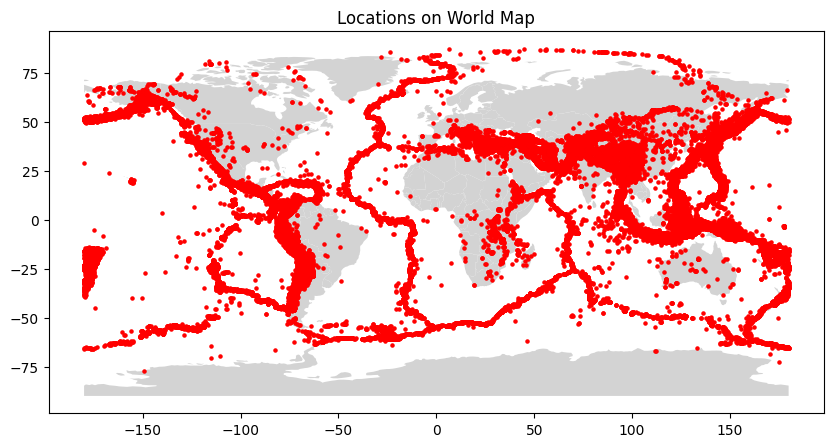

In [7]:
world = gpd.read_file("/content/ne_110m_admin_0_countries.shp")

fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray')

gdf.plot(ax=ax, color='red', markersize=5)

plt.title("Locations on World Map")
plt.show()

#Clustering Algorithms

###Importing Libraries for Clustering

In [21]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
from sklearn.cluster import OPTICS

##DBScan
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points based on density. It works well when clusters have different shapes, but it struggles when densities vary too much. The main challenge is choosing eps—too small and you get too many noise points, too large and clusters merge incorrectly.


In [26]:
for i in range(len(locations)):
  locations[i] = locations[i] + (df['depth'][i],)

locations = np.array(locations)
print(locations)

[[ 41.802  23.108  15.   ]
 [ 41.758  23.249  15.   ]
 [ 51.424 161.638  15.   ]
 ...
 [ -8.733 122.233 130.8  ]
 [ -0.793 146.809  14.4  ]
 [ -9.127 119.007  97.6  ]]


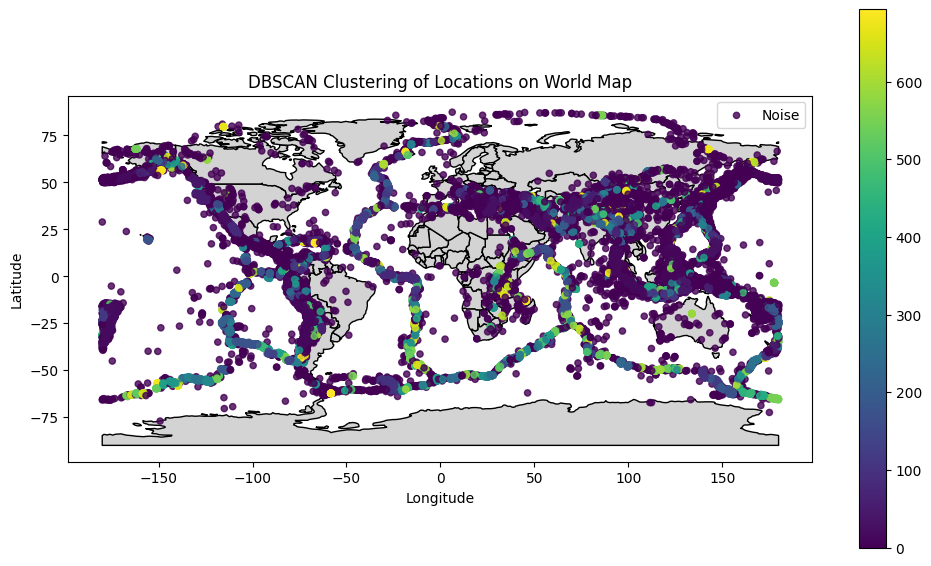

In [16]:
locations = np.array(locations)

# Normalize depth to balance its scale with latitude and longitude
scaler = StandardScaler()
locations[:, 2] = scaler.fit_transform(locations[:, 2].reshape(-1, 1)).flatten()

# Apply DBSCAN clustering
eps = 0.5  # Adjust based on data scale
min_samples = 7
db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(locations)

# Get cluster labels
labels = db.labels_
unique_labels = set(labels)

# Convert clustered points into a GeoDataFrame
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(locations[:, 1], locations[:, 0]),
    data={"Cluster": labels}
)

# Plot world map
fig, ax = plt.subplots(figsize=(12, 7))
world.plot(ax=ax, color="lightgray", edgecolor="black")

# Plot clustered points with different colors
gdf.plot(ax=ax, column="Cluster", cmap="viridis", markersize=20, legend=True, alpha=0.8)

# Labels & Title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Locations on World Map")
plt.legend(["Noise", "Clusters"])
plt.show()

### Performance Metrics
We used Silhouette Score, Davies-Bouldin Index, and Calinski-Harabasz Score to evaluate clustering quality. Silhouette measures how well-separated clusters are, DB Index checks how compact they are, and CH Score favors distinct, well-spread clusters.


0.5
3 4 5 6 7 0.7
3 4 5 6 7 0.9
3 4 5 6 7 1.1
3 4 5 6 7 1.3
3 4 5 6 7 1.5
3 4 5 6 7 

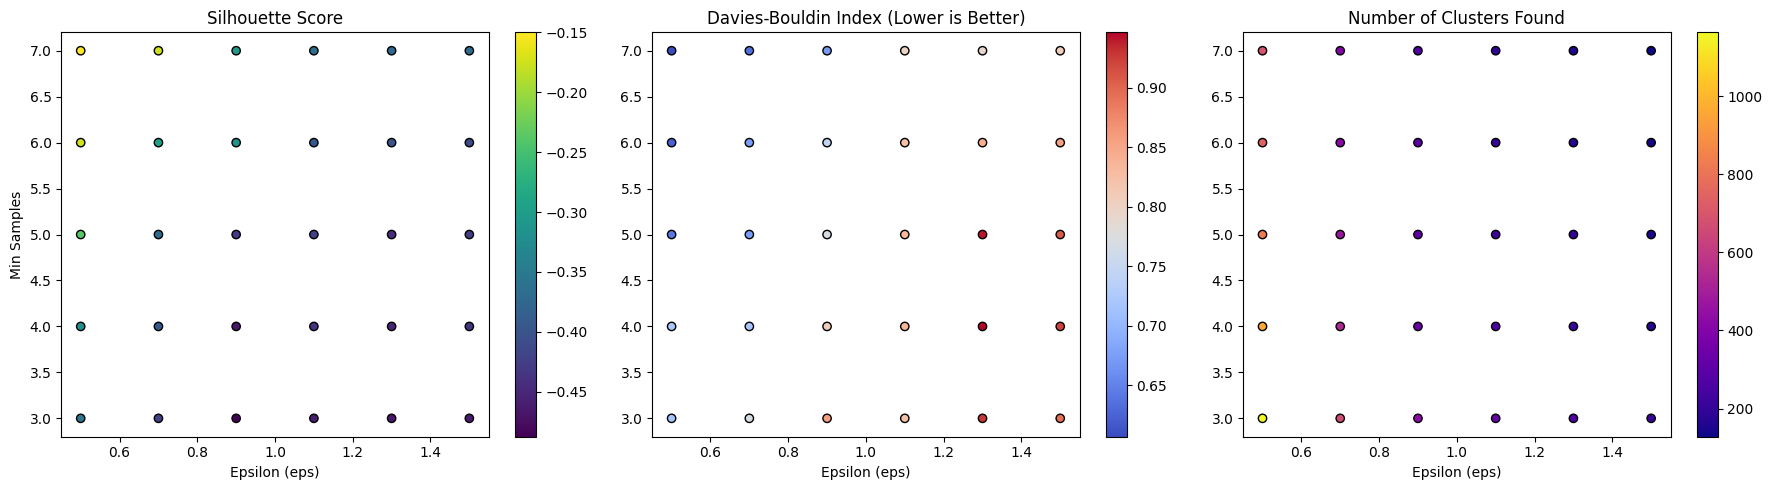

In [13]:
scaler = StandardScaler()
locations[:, 2] = scaler.fit_transform(locations[:, 2].reshape(-1, 1)).flatten()

# Define hyperparameter ranges
eps_values = np.linspace(0.5, 1.5, 6)
min_samples_values = range(3, 8)

# Store results
results = []

# Grid Search Over Parameters
for eps in eps_values:
    print(eps)
    for min_samples in min_samples_values:
        print(min_samples, end = " ")

        db = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean").fit(locations)
        labels = db.labels_

        # Remove noise points (-1) for evaluation
        core_samples = locations[labels != -1]
        core_labels = labels[labels != -1]

        # Compute metrics only if we have at least 2 clusters
        if len(set(core_labels)) > 1:
            silhouette = silhouette_score(core_samples, core_labels)
            db_index = davies_bouldin_score(core_samples, core_labels)
            ch_score = calinski_harabasz_score(core_samples, core_labels)
        else:
            silhouette, db_index, ch_score = None, None, None

        # Store results
        results.append((eps, min_samples, silhouette, db_index, ch_score, len(set(core_labels))))

# Convert results to array
results = np.array(results, dtype=object)

# Extract metrics for plotting
eps_grid = results[:, 0].astype(float)
min_samples_grid = results[:, 1].astype(int)
sil_scores = np.array([x if x is not None else 0 for x in results[:, 2]])
db_scores = np.array([x if x is not None else np.nan for x in results[:, 3]])
ch_scores = np.array([x if x is not None else 0 for x in results[:, 4]])
num_clusters = results[:, 5].astype(int)

# Plot Results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette Score Plot
sc = axes[0].scatter(eps_grid, min_samples_grid, c=sil_scores, cmap="viridis", edgecolors="k")
axes[0].set_title("Silhouette Score")
axes[0].set_xlabel("Epsilon (eps)")
axes[0].set_ylabel("Min Samples")
fig.colorbar(sc, ax=axes[0])

# Davies-Bouldin Score Plot
sc = axes[1].scatter(eps_grid, min_samples_grid, c=db_scores, cmap="coolwarm", edgecolors="k")
axes[1].set_title("Davies-Bouldin Index (Lower is Better)")
axes[1].set_xlabel("Epsilon (eps)")
fig.colorbar(sc, ax=axes[1])

# Number of Clusters Found
sc = axes[2].scatter(eps_grid, min_samples_grid, c=num_clusters, cmap="plasma", edgecolors="k")
axes[2].set_title("Number of Clusters Found")
axes[2].set_xlabel("Epsilon (eps)")
fig.colorbar(sc, ax=axes[2])

plt.tight_layout()
plt.show()

In [15]:
# Filter out None values from Silhouette Scores
valid_results = results[~np.isnan(sil_scores)]

if valid_results.size > 0:
    # Get the index of the best Silhouette Score
    best_idx = np.argmax(sil_scores)

    # Extract the best parameters
    best_eps = results[best_idx, 0]
    best_min_samples = results[best_idx, 1]
    best_silhouette_score = results[best_idx, 2]

    print(f"✅ Best Hyperparameters Found:")
    print(f"   - Epsilon (eps): {best_eps}")
    print(f"   - Min Samples: {best_min_samples}")
    print(f"   - Best Silhouette Score: {best_silhouette_score:.4f}")
else:
    print("⚠️ No valid clustering found. Try adjusting the eps or min_samples range.")
    best_eps, best_min_samples = None, None


✅ Best Hyperparameters Found:
   - Epsilon (eps): 0.5
   - Min Samples: 7
   - Best Silhouette Score: -0.1499


A negative Silhouette Score means points are closer to other clusters than their own. This happens when clusters overlap or when too many points are marked as noise, making the remaining clusters poorly defined.

## HDBSCAN
HDBSCAN is an improvement over DBSCAN that automatically finds the best eps and can identify clusters of different densities. It’s great for large datasets and handles variable-density clustering better than DBSCAN. However, it still struggles when data lacks clear density variations.



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


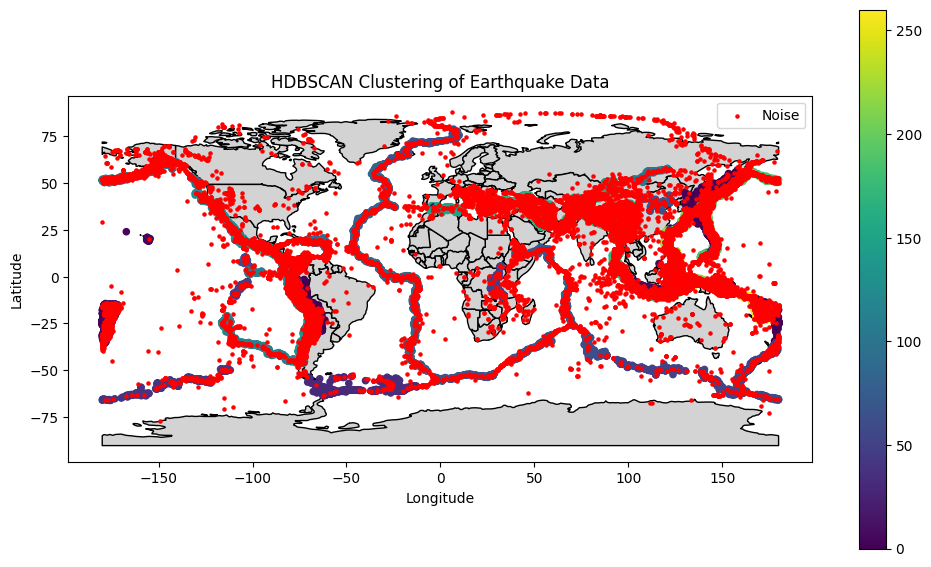

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(locations)

# Convert to GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(locations[:, 1], locations[:, 0]),
    data={"Cluster": labels}
)

# Plot results
fig, ax = plt.subplots(figsize=(12, 7))
world.plot(ax=ax, color="lightgray", edgecolor="black")

# Plot clustered points
gdf[gdf["Cluster"] != -1].plot(ax=ax, column="Cluster", cmap="viridis", markersize=20, legend=True)

# Plot noise points
gdf[gdf["Cluster"] == -1].plot(ax=ax, color="red", markersize=5, label="Noise")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("HDBSCAN Clustering of Earthquake Data")
plt.legend()
plt.show()

In [44]:
core_samples = locations[labels != -1]
core_labels = labels[labels != -1]

# Compute silhouette score only if at least 2 clusters exist
if len(set(core_labels)) > 1:
    silhouette = silhouette_score(core_samples, core_labels)
else:
    silhouette = None

print(f"✅ Silhouette Score: {silhouette}")

✅ Silhouette Score: 0.44544709741024097


### Trying HDBSCAN for samller subset of the data

As HDBSCAN is producing decent results in comparison to other methods, we will try to reduce number of earthquakes to reduce density and evaluate performance

We will use random 10,000 recorded earthquakes

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


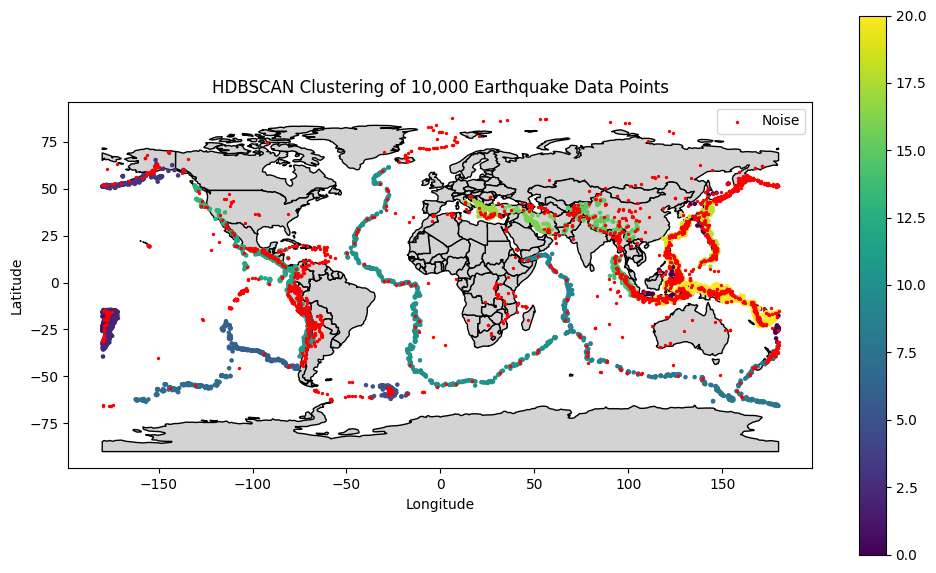

In [45]:
num_samples = 10000

# Randomly select 10,000 points without replacement
indices = np.random.choice(locations.shape[0], num_samples, replace=False)
location_new = locations[indices]

# Run HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(locations_new)

# Convert to GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(locations_new[:, 1], locations_new[:, 0]),  # Longitude, Latitude
    data={"Cluster": labels}
)

# Plot results
fig, ax = plt.subplots(figsize=(12, 7))
world.plot(ax=ax, color="lightgray", edgecolor="black")

# Plot clustered points
gdf[gdf["Cluster"] != -1].plot(ax=ax, column="Cluster", cmap="viridis", markersize=5, legend=True)

# Plot noise points
gdf[gdf["Cluster"] == -1].plot(ax=ax, color="red", markersize=2, label="Noise")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("HDBSCAN Clustering of 10,000 Earthquake Data Points")
plt.legend()
plt.show()

In [46]:
core_samples = locations_new[labels != -1]
core_labels = labels[labels != -1]

# Compute silhouette score only if at least 2 clusters exist
if len(set(core_labels)) > 1:
    silhouette = silhouette_score(core_samples, core_labels)
else:
    silhouette = None

print(f"✅ Silhouette Score: {silhouette}")

✅ Silhouette Score: 0.3482536508616005


As observed when the dataset is reduced in size, the number of noise points reduces significantly and we get better results.

Number of clusters in this case = 9

## OPTICS
OPTICS is like DBSCAN but doesn’t require a fixed eps. It orders points based on density, making it useful for finding clusters at multiple scales. It’s more flexible than DBSCAN but can still produce too many noise points if the dataset is highly variable.

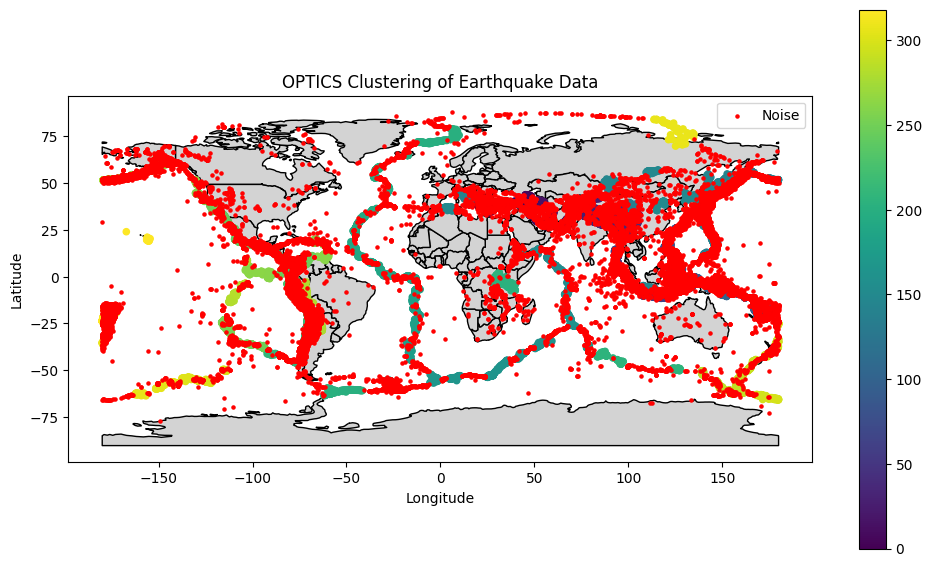

In [22]:
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=50, metric="euclidean")
labels = optics.fit_predict(locations)

# Convert to GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(locations[:, 1], locations[:, 0]),
    data={"Cluster": labels}
)

# Plot results
fig, ax = plt.subplots(figsize=(12, 7))
world.plot(ax=ax, color="lightgray", edgecolor="black")

# Plot clustered points
gdf[gdf["Cluster"] != -1].plot(ax=ax, column="Cluster", cmap="viridis", markersize=20, legend=True)

# Plot noise points
gdf[gdf["Cluster"] == -1].plot(ax=ax, color="red", markersize=5, label="Noise")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("OPTICS Clustering of Earthquake Data")
plt.legend()
plt.show()

### Trying OPTICS for a smaller dataset
We will try OPTICS with last 10,000 recorded earthquakes

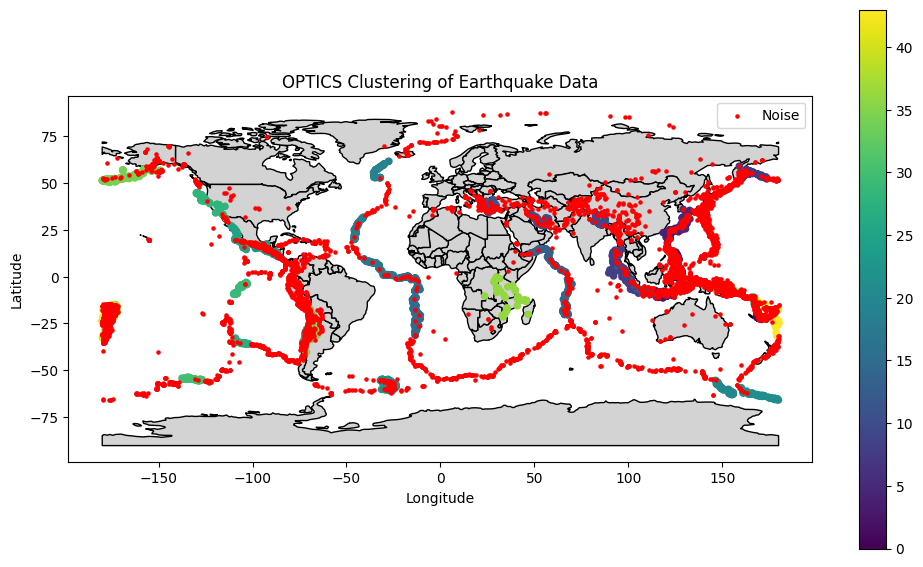

In [39]:
optics = OPTICS(min_samples=10, xi=0.05, min_cluster_size=50, metric="euclidean")
labels = optics.fit_predict(locations_new)

# Convert to GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(locations_new[:, 1], locations_new[:, 0]),
    data={"Cluster": labels}
)

# Plot results
fig, ax = plt.subplots(figsize=(12, 7))
world.plot(ax=ax, color="lightgray", edgecolor="black")

# Plot clustered points
gdf[gdf["Cluster"] != -1].plot(ax=ax, column="Cluster", cmap="viridis", markersize=20, legend=True)

# Plot noise points
gdf[gdf["Cluster"] == -1].plot(ax=ax, color="red", markersize=5, label="Noise")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("OPTICS Clustering of Earthquake Data")
plt.legend()
plt.show()

# Overall Conclusion
1.   Density-based methods work well for spatial data like earthquakes but struggle when density varies too much or data is too sparse.
2.   Since DBSCAN, HDBSCAN, and OPTICS all rely on density estimation, they can misclassify many points as noise.
3. For large datasets (70,000+ points), model-based clustering like Gaussian Mixture Models (GMM) or hierarchical clustering might perform better.
4. When we limit the number of points, we seemingly get better results in these density based functions.
